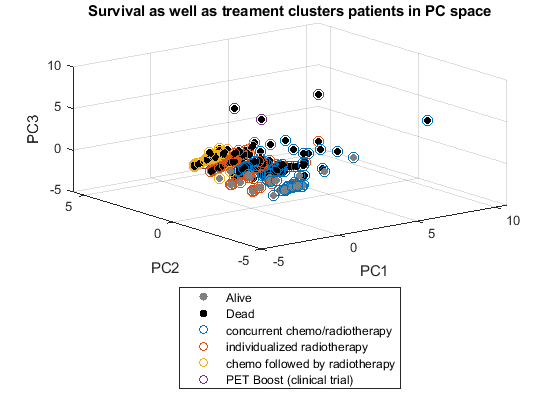

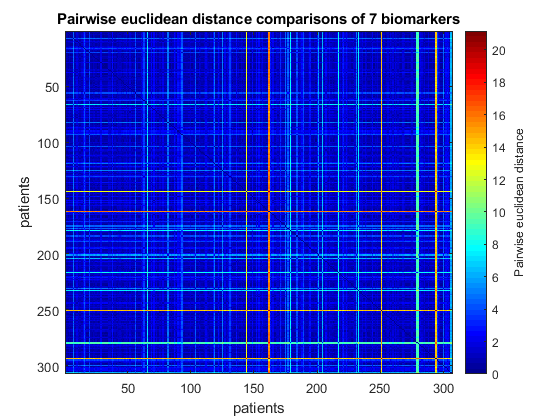

In [21]:
%plot inline

[data1num,data1txt,data1raw] = xlsread('carvalho-prognostic-biomarkers-NSCLC',2);
[data2num,data2txt,data2raw] = xlsread('carvalho-prognostic-biomarkers-NSCLC',3);
[normnum,normtxt,normraw] = xlsread('NormalBiomarkerRange');



rng(0,'twister');
for analyteind=1:size(normnum,2)%simulate data within healthy range (currently imcomplete)
rangemin=normnum(1,analyteind);
rangemax=normnum(2,analyteind);
normsimulation(:,analyteind)=(rangemax-rangemin).*rand(200,1)+rangemin;
end
normsimulation(:,8)=repmat(3, 200,1);

%merge biomarker data from developmental dataset and validation dataset
data1numsubset=data1num(:,13:19); 
data1numsubset(:,8)=repmat(1, size(data1num,1),1);%indicate developmental dataset  
data2numsubset=data2num(:,13:19); 
data2numsubset(:,8)=repmat(2, size(data2num,1),1);%indicate validation dataset

datamerged=[data1numsubset;data2numsubset;normsimulation];%for use when normal dataset is ready

%determine survival, convert str to number value, alive=1 dead=2, merge to biomarker data
[des1 a1 c1]=unique(data1raw(2:end,2));
data1numsubset(:,9)=c1;
[des2 a2 c2]=unique(data2raw(2:end,2));
data2numsubset(:,9)=c2;

%determine disease stage, convert to number value I=1 II=2 IIIa=3 IIIb=4
%unknown=5
[stage1, stage1a, stage1c]=unique(data1raw(2:end,5));
data2raw{103,5}='unknown';
data2raw{173,5}='unknown';
[stage2, stage2a, stage2c]=unique(data2raw(2:end,5));
stage=[stage1c;stage2c];

%determine treament regimen, convert to number value concurrent=1 new=2 standard=3 PET=4  
[treatment1 treatment1a treatment1c]=unique(data1raw(2:end,11));
[treatment2 treatment2a treatment2c]=unique(data2raw(2:end,11));
treatment2c(find(treatment2c==3))=4;
treatment=[treatment1c;treatment2c];

diseasemerged=[data1numsubset;data2numsubset];%merge diseas biomarker data (biomarkers 1:7)
cleaneddata=datamerged;
cleaneddata(any(isnan(cleaneddata),2),:)=[];%remove patients with missing biomarker data
cleaneddisease=diseasemerged;
cleaneddisease(:,10)=stage;%add stage info
cleaneddisease(:,11)=treatment;%add treatment info
cleaneddisease(any(isnan(cleaneddisease),2),:)=[];%remove patients with missing biomarker data
cleanedalive=length(find(cleaneddisease(:,9)==1));
cleaneddead=length(find(cleaneddisease(:,9)==2));
alive2dead=cleanedalive/cleaneddead;


dataz=zscore(cleaneddisease(:,1:7));
D=pdist(dataz);
Z=squareform(D);stdevmean=std(mean(Z));avgZ=(mean(Z));
figure;colormap('jet');  imagesc(Z);
xlabel('patients');ylabel('patients'); title('Pairwise euclidean distance comparisons of 7 biomarkers');
h=colorbar;
ylabel(h, 'Pairwise euclidean distance');set(gca,'FontSize',10)
highvals=find(avgZ>2*stdevmean);
alivevals=find(cleaneddisease(:,9)==1);
deadvals=find(cleaneddisease(:,9)==2);
mortalitywhenhighZ=cleaneddisease(highvals,9);
numalivehighZ=length(find(mortalitywhenhighZ==1));
numdeadhighZ=length(find(mortalitywhenhighZ==2));
highzalive2dead=numalivehighZ/numdeadhighZ;



[coeff,score,latent,tsquared,explained,mu] = pca(zscore(cleaneddisease));

figure;
C=colormap('lines');

scatter3(score(find(cleaneddisease(:,9)==1),1),score(find(cleaneddisease(:,9)==1),2),score(find(cleaneddisease(:,9)==1),3),30,[0.5 0.5 0.5],'filled');hold on;
scatter3(score(find(cleaneddisease(:,9)==2),1),score(find(cleaneddisease(:,9)==2),2),score(find(cleaneddisease(:,9)==2),3),30,'k','filled');hold on;
 
scatter3(score(find(cleaneddisease(:,11)==1),1),score(find(cleaneddisease(:,11)==1),2),score(find(cleaneddisease(:,11)==1),3),60,C(1,:));hold on;
scatter3(score(find(cleaneddisease(:,11)==2),1),score(find(cleaneddisease(:,11)==2),2),score(find(cleaneddisease(:,11)==2),3),60,C(2,:));hold on;
scatter3(score(find(cleaneddisease(:,11)==3),1),score(find(cleaneddisease(:,11)==3),2),score(find(cleaneddisease(:,11)==3),3),60,C(3,:));hold on;
scatter3(score(find(cleaneddisease(:,11)==4),1),score(find(cleaneddisease(:,11)==4),2),score(find(cleaneddisease(:,11)==4),3),60,C(4,:));hold on;

xlabel('PC1');ylabel('PC2');zlabel('PC3');title('Survival as well as treament clusters patients in PC space');set(gca,'FontSize',10)

legend('Alive','Dead', 'concurrent chemo/radiotherapy', 'individualized radiotherapy', 'chemo followed by radiotherapy', 'PET Boost (clinical trial)','Location','southoutside')